
<h1><center id="title">DataLab Cup 3: Reverse Image Caption</center></h1>

<center id="author">Shan-Hung Wu &amp; DataLab<br/>Fall 2025</center>




<h1><center class="subtitle">Text to Image</center></h1>

<h2 id="Platform:-Kaggle">Platform: <a href="https://www.kaggle.com/competitions/2025-datalab-cup-3-reverse-image-caption/overview">Kaggle</a><a class="anchor-link" href="#Platform:-Kaggle">¶</a></h2>
<h2 id="Overview">Overview<a class="anchor-link" href="#Overview">¶</a></h2>
<p>In this work, we are interested in translating text in the form of single-sentence human-written descriptions directly into image pixels. For example, "<strong>this flower has petals that are yellow and has a ruffled stamen</strong>" and "<strong>this pink and yellow flower has a beautiful yellow center with many stamens</strong>". You have to develop a novel deep architecture and GAN formulation to effectively translate visual concepts from characters to pixels.</p>

<p>More specifically, given a set of texts, your task is to generate reasonable images with size 64x64x3 to illustrate the corresponding texts. Here we use <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Oxford-102 flower dataset</a> and its <a href="https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view">paired texts</a> as our training dataset.</p>

<img alt="No description has been provided for this image" src="./data/example.png"/>

<ul>
<li>7370 images as training set, where each images is annotated with at most 10 texts.</li>
<li>819 texts for testing. You must generate 1 64x64x3 image for each text.</li>
</ul>




<h2 id="Conditional-GAN">Conditional GAN<a class="anchor-link" href="#Conditional-GAN">¶</a></h2>
<p>Given a text, in order to generate the image which can illustrate it, our model must meet several requirements:</p>

<ol>
<li>Our model should have ability to understand and extract the meaning of given texts.<ul>
<li>Use RNN or other language model, such as BERT, ELMo or XLNet, to capture the meaning of text.</li>
</ul>
</li>
<li>Our model should be able to generate image.<ul>
<li>Use GAN to generate high quality image.</li>
</ul>
</li>
<li>GAN-generated image should illustrate the text.<ul>
<li>Use conditional-GAN to generate image conditioned on given text.</li>
</ul>
</li>
</ol>

<p>Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information $y$. We can perform the conditioning by feeding $y$ into both the discriminator and generator as additional input layer.</p>

<img alt="No description has been provided for this image" src="./data/cGAN.png" width="500"/>

<p>There are two motivations for using some extra information in a GAN model:</p>

<ol>
<li>Improve GAN.</li>
<li>Generate targeted image.</li>
</ol>

<p>Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality.</p>

<img alt="No description has been provided for this image" src="./data/GANCLS.jpg"/>



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tqdm import tqdm

import re
from IPython import display

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



<h2 id="Preprocess-Text">Preprocess Text<a class="anchor-link" href="#Preprocess-Text">¶</a></h2>
<p>Since dealing with raw string is inefficient, we have done some data preprocessing for you:</p>

<ul>
<li>Delete text over <code>MAX_SEQ_LENGTH (20)</code>.</li>
<li>Delete all puntuation in the texts.</li>
<li>Encode each vocabulary in <code>dictionary/vocab.npy</code>.</li>
<li>Represent texts by a sequence of integer IDs.</li>
<li>Replace rare words by <code>&lt;RARE&gt;</code> token to reduce vocabulary size for more efficient training.</li>
<li>Add padding as <code>&lt;PAD&gt;</code> to each text to make sure all of them have equal length to <code>MAX_SEQ_LENGTH (20)</code>.</li>
</ul>

<p>It is worth knowing that there is no necessary to append <code>&lt;ST&gt;</code> and <code>&lt;ED&gt;</code> to each text because we don't need to generate any sequence in this task.</p>

<p>To make sure correctness of encoding of the original text, we can decode sequence vocabulary IDs by looking up the vocabulary dictionary:</p>

<ul>
<li><code>dictionary/word2Id.npy</code> is a numpy array mapping word to id.</li>
<li><code>dictionary/id2Word.npy</code> is a numpy array mapping id back to word.</li>
</ul>



In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))


there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
# This cell previously contained sent2IdList() function
# It has been removed as we now use DistilBERT tokenizer instead
# The id2word_dict is still available from cell 6 for visualization purposes

print("✓ Using DistilBERT tokenizer (sent2IdList removed)")

✓ Using DistilBERT tokenizer (sent2IdList removed)



<h2 id="Dataset">Dataset<a class="anchor-link" href="#Dataset">¶</a></h2>
<p>For training, the following files are in dataset folder:</p>

<ul>
<li><code>./dataset/text2ImgData.pkl</code> is a pandas dataframe with attribute 'Captions' and 'ImagePath'.<ul>
<li>'Captions' : A list of text id list contain 1 to 10 captions.</li>
<li>'ImagePath': Image path that store paired image.</li>
</ul>
</li>
<li><code>./102flowers/</code> is the directory containing all training images.</li>
<li><code>./dataset/testData.pkl</code> is a pandas a dataframe with attribute 'ID' and 'Captions', which contains testing data.</li>
</ul>



In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))


There are 7370 image in training data


In [6]:
df.head(5)


,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [7]:
# Data Augmentation Configuration
# Define this BEFORE training_data_generator to avoid reference issues
aug_config = {
    'enabled': True,                      # Master switch for augmentation
    'random_flip_horizontal': True,       # Flowers can be mirrored
    'random_flip_vertical': False,        # Flowers typically grow upward
    'random_rotation': True,              # Any rotation is valid for flowers
    'random_brightness': 0.15,            # Lighting variations (max delta)
    'random_contrast': (0.9, 1.1),        # Subtle contrast changes (lower, upper)
    'random_saturation': (0.9, 1.1),      # Color intensity (lower, upper)
    'random_hue': 0.05,                   # Small color shifts (max delta)
}

print('Data Augmentation:', 'ENABLED' if aug_config['enabled'] else 'DISABLED')
if aug_config['enabled']:
    enabled_augs = [k for k, v in aug_config.items() if k != 'enabled' and v]
    print(f'Active augmentations: {", ".join(enabled_augs)}')

Data Augmentation: ENABLED
Active augmentations: random_flip_horizontal, random_rotation, random_brightness, random_contrast, random_saturation, random_hue



<h2 id="Create-Dataset-by-Dataset-API">Create Dataset by Dataset API<a class="anchor-link" href="#Create-Dataset-by-Dataset-API">¶</a></h2>



In [8]:
# IMPORTANT: Import TensorFlow FIRST before transformers
import tensorflow as tf
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_text_distilbert(text, max_length=64):

    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )


    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }

/opt/anaconda3/envs/DL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption_text, image_path):
    """
    Updated data generator using DistilBERT tokenization
    
    Args:
        caption_text: Raw text string (not IDs!)
        image_path: Path to image file
    
    Returns:
        img, input_ids, attention_mask
    """
    # ============= IMAGE PROCESSING (same as before) =============
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1]
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    
    # Data augmentation (only applied during training)
    if aug_config['enabled']:
        if aug_config['random_flip_horizontal']:
            img = tf.image.random_flip_left_right(img)
        
        if aug_config['random_flip_vertical']:
            img = tf.image.random_flip_up_down(img)
        
        if aug_config['random_rotation']:
            img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        
        if aug_config['random_brightness']:
            img = tf.image.random_brightness(img, aug_config['random_brightness'])
        
        if aug_config['random_contrast']:
            img = tf.image.random_contrast(img, 
                                          aug_config['random_contrast'][0], 
                                          aug_config['random_contrast'][1])
        
        if aug_config['random_saturation']:
            img = tf.image.random_saturation(img, 
                                            aug_config['random_saturation'][0], 
                                            aug_config['random_saturation'][1])
        
        if aug_config['random_hue']:
            img = tf.image.random_hue(img, aug_config['random_hue'])
        
        img = tf.clip_by_value(img, 0.0, 1.0)
    
    # Normalize to [-1, 1] to match generator's tanh output
    img = (img * 2.0) - 1.0
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    # ============= TEXT PROCESSING (NEW: Use DistilBERT tokenizer) =============
    def tokenize_caption(text):
        """Python function to tokenize text using DistilBERT tokenizer"""
        # Decode bytes to string if needed
        if isinstance(text, bytes):
            text = text.decode('utf-8')
        
        # Tokenize using DistilBERT
        encoded = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='np'  # Use numpy arrays for TF compatibility
        )
        
        return encoded['input_ids'][0], encoded['attention_mask'][0]
    
    # Use tf.py_function to call Python tokenizer
    input_ids, attention_mask = tf.py_function(
        func=tokenize_caption,
        inp=[caption_text],
        Tout=[tf.int32, tf.int32]
    )
    
    # Set shapes explicitly
    input_ids.set_shape([64])
    attention_mask.set_shape([64])
    
    return img, input_ids, attention_mask

def dataset_generator(filenames, batch_size, data_generator):
    """
    Updated dataset generator to work with raw text (decoded from IDs)
    """
    # Load the training data
    df = pd.read_pickle(filenames)
    captions_ids = df['Captions'].values
    caption_texts = []
    
    # Decode pre-tokenized IDs back to raw text
    for i in range(len(captions_ids)):
        # Randomly choose one caption (list of ID lists)
        chosen_caption_ids = random.choice(captions_ids[i])
        
        # Decode IDs back to text using id2word_dict
        words = []
        for word_id in chosen_caption_ids:
            word = id2word_dict[str(word_id)]
            if word != '<PAD>':  # Skip padding tokens
                words.append(word)
        
        caption_text = ' '.join(words)
        caption_texts.append(caption_text)
    
    image_paths = df['ImagePath'].values
    
    # Verify same length
    assert len(caption_texts) == len(image_paths)
    
    # Create dataset from raw text and image paths
    dataset = tf.data.Dataset.from_tensor_slices((caption_texts, image_paths))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(caption_texts)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [10]:
BATCH_SIZE = 16
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)


<h2 id="Conditional-GAN-Model">Conditional GAN Model<a class="anchor-link" href="#Conditional-GAN-Model">¶</a></h2>
<p>As mentioned above, there are three models in this task, text encoder, generator and discriminator.</p>

<h2 id="Text-Encoder">Text Encoder<a class="anchor-link" href="#Text-Encoder">¶</a></h2>
<p>A RNN encoder that captures the meaning of input text.</p>

<ul>
<li>Input: text, which is a list of ids.</li>
<li>Output: embedding, or hidden representation of input text.</li>
</ul>



In [11]:
# IMPORTANT: Import TensorFlow FIRST before transformers
import tensorflow as tf
from transformers import TFDistilBertModel

class DistillBertEncoder(tf.keras.Model):
    def __init__(self, output_dim=128, freeze_bert=True):
        super(DistillBertEncoder, self).__init__()
        
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

        if(freeze_bert):
            self.distilbert.trainable = False

        self.projection = tf.keras.layers.Dense(output_dim, activation='relu')
    
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, input_ids, attention_mask, training=False):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask, training=training)

        cls_embedding = outputs.last_hidden_state[:, 0, :]
        
        cls_embedding = self.dropout(cls_embedding, training=training)

        text_features = self.projection(cls_embedding)

        return text_features


<h2 id="Generator">Generator<a class="anchor-link" href="#Generator">¶</a></h2>
<p>A image generator which generates the target image illustrating the input text.</p>

<ul>
<li>Input: hidden representation of input text and random noise z with random seed.</li>
<li>Output: target image, which is conditioned on the given text, in size 64x64x3.</li>
</ul>



In [12]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d2(text_concat)
        
        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)
        
        return logits, output



<h2 id="Discriminator">Discriminator<a class="anchor-link" href="#Discriminator">¶</a></h2>
<p>A binary classifier which can discriminate the real and fake image:</p>

<ol>
<li>Real image<ul>
<li>Input: real image and the paired text</li>
<li>Output: a floating number representing the result, which is expected to be 1.</li>
</ul>
</li>
<li>Fake Image<ul>
<li>Input: generated image and paired text</li>
<li>Output: a floating number representing the result, which is expected to be 0.</li>
</ul>
</li>
</ol>



In [13]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
    
    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)
        
        img = self.flatten(img)
        img = self.d_img(img)
        img = tf.nn.leaky_relu(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output


In [14]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': BATCH_SIZE,                 # Use BATCH_SIZE from cell 14 (single source of truth)
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 100,                           # number of epoch for demo
    'N_SAMPLE': num_training_sample,          # size of training data
    'PRINT_FREQ': 20                          # printing frequency of loss
}

In [15]:
text_encoder = DistillBertEncoder(output_dim=hparas['RNN_HIDDEN_SIZE'], freeze_bert=True)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

ImportError: 
TFDistilBertModel requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.



<h2 id="Loss-Function-and-Optimization">Loss Function and Optimization<a class="anchor-link" href="#Loss-Function-and-Optimization">¶</a></h2>
<p>Although the conditional GAN model is quite complex, the loss function used to optimize the network is relatively simple. Actually, it is simply a binary classification task, thus we use cross entropy as our loss.</p>



In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])


In [ ]:
# Create checkpoint object (directory will be set later in cell 35)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(real_image, input_ids, attention_mask):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Encode text with DistilBERT (no hidden state returned)
        text_embed = text_encoder(input_ids, attention_mask, training=True)
        _, fake_image = generator(text_embed, noise)
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss

In [ ]:
@tf.function
def test_step(input_ids, attention_mask, noise):
    # Encode text with DistilBERT (no hidden state)
    text_embed = text_encoder(input_ids, attention_mask, training=False)
    _, fake_image = generator(text_embed, noise)
    return fake_image


<h2 id="Visualiztion">Visualiztion<a class="anchor-link" href="#Visualiztion">¶</a></h2>
<p>During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.</p>



In [ ]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)



<p>We always use same random seed and same senteces during training, which is more convenient for us to evaluate the quality of generated image.</p>



In [ ]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentences = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                   ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                   ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                   ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                   ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                   ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                   ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                   ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

# Tokenize with DistilBERT (no more sent2IdList!)
sample_encoded = preprocess_text_distilbert(sample_sentences, max_length=64)
sample_input_ids = sample_encoded['input_ids']
sample_attention_mask = sample_encoded['attention_mask']

print(f"Sample sentences tokenized: {len(sample_sentences)} sentences")
print(f"Input IDs shape: {sample_input_ids.shape}")
print(f"Attention mask shape: {sample_attention_mask.shape}")


<h2 id="Training">Training<a class="anchor-link" href="#Training">¶</a></h2>



In [ ]:
from datetime import datetime

# Create a unified run directory with timestamp
run_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
run_dir = f'runs/{run_timestamp}'

# All outputs for this run go in subdirectories
checkpoint_dir = f'{run_dir}/checkpoints'
samples_dir = f'{run_dir}/samples'
inference_dir = f'{run_dir}/inference'

# Create all directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(inference_dir, exist_ok=True)

print(f'Created run directory: {run_dir}')
print(f'  ├── checkpoints/ : {checkpoint_dir}')
print(f'  ├── samples/     : {samples_dir}')
print(f'  └── inference/   : {inference_dir}')

Created run directory: runs/20251116-204819
  ├── checkpoints/ : runs/20251116-204819/checkpoints
  ├── samples/     : runs/20251116-204819/samples
  └── inference/   : runs/20251116-204819/inference


In [ ]:
import json

# Save hyperparameters and configuration for reproducibility
config = {
    'run_timestamp': run_timestamp,
    'run_dir': run_dir,
    'hyperparameters': hparas.copy(),
    'augmentation': aug_config.copy(),  # Track augmentation settings
    'model_architecture': {
        'text_encoder': 'GRU',
        'generator': 'Dense',
        'discriminator': 'Dense'
    }
}

config_path = f'{run_dir}/config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f'✓ Configuration saved to: {config_path}')

✓ Configuration saved to: runs/20251116-204819/config.json


In [ ]:
def train(dataset, epochs):
    # Use the run directories created in cell 36
    global run_dir, checkpoint_dir, samples_dir, inference_dir
    
    # Create checkpoint prefix
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    
    print(f'Training run: {run_dir}')
    
    # No hidden state needed for DistilBERT
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        # Progress bar for each epoch
        pbar = tqdm(dataset, desc=f'Epoch {epoch+1}/{hparas["N_EPOCH"]}', 
                   total=steps_per_epoch, unit='batch')
        
        # Unpack 3 values: image, input_ids, attention_mask
        for image, input_ids, attention_mask in pbar:
            g_loss, d_loss = train_step(image, input_ids, attention_mask)
            g_total_loss += g_loss
            d_total_loss += d_loss
            
            # Update progress bar with current losses
            pbar.set_postfix({
                'G_loss': f'{g_loss:.4f}',
                'D_loss': f'{d_loss:.4f}'
            })
        
        pbar.close()
        
        # Print epoch summary
        avg_g_loss = g_total_loss / steps_per_epoch
        avg_d_loss = d_total_loss / steps_per_epoch
        epoch_time = time.time() - start
        print(f'Epoch {epoch+1}: G_loss={avg_g_loss:.4f}, D_loss={avg_d_loss:.4f}, Time={epoch_time:.2f}s')
        
        # save the model
        if (epoch + 1) % 50 == 0:
            saved_path = checkpoint.save(file_prefix = checkpoint_prefix)
            print(f'  ✓ Checkpoint saved: {saved_path}')
        
        # visualization - save to timestamped directory
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            # Use pre-tokenized sample data from cell 34
            fake_image = test_step(sample_input_ids, sample_attention_mask, sample_seed)
            save_images(fake_image, [ni, ni], f'{samples_dir}/train_{epoch+1:03d}.jpg')
            print(f'  ✓ Sample image saved')
    
    print('\n✓ Training completed!')
    print(f'All outputs saved to: {run_dir}')

In [ ]:
train(dataset, hparas['N_EPOCH'])


Training run: runs/20251116-204819


Epoch 1/100:  29%|██▉       | 133/460 [00:09<00:22, 14.40batch/s, G_loss=1.1910, D_loss=0.4734]


KeyboardInterrupt: 


<h1><center class="subtitle">Evaluation</center></h1>

<p><code>dataset/testData.pkl</code> is a pandas dataframe containing testing text with attributes 'ID' and 'Captions'.</p>

<ul>
<li>'ID': text ID used to name generated image.</li>
<li>'Captions': text used as condition to generate image.</li>
</ul>

<p>For each captions, you need to generate <strong>inference_ID.png</strong> to evaluate quality of generated image. You must name the generated image in this format, otherwise we cannot evaluate your images.</p>




<h2 id="Testing-Dataset">Testing Dataset<a class="anchor-link" href="#Testing-Dataset">¶</a></h2>
<p>If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.</p>



In [ ]:
def testing_data_generator(caption_text, index):
    """
    Updated testing data generator using DistilBERT tokenization
    
    Args:
        caption_text: Raw text string
        index: Test sample ID
    
    Returns:
        input_ids, attention_mask, index
    """
    def tokenize_caption(text):
        """Python function to tokenize text using DistilBERT tokenizer"""
        if isinstance(text, bytes):
            text = text.decode('utf-8')
        
        encoded = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='np'
        )
        
        return encoded['input_ids'][0], encoded['attention_mask'][0]
    
    # Use tf.py_function to call Python tokenizer
    input_ids, attention_mask = tf.py_function(
        func=tokenize_caption,
        inp=[caption_text],
        Tout=[tf.int32, tf.int32]
    )
    
    # Set shapes explicitly
    input_ids.set_shape([64])
    attention_mask.set_shape([64])
    
    return input_ids, attention_mask, index

def testing_dataset_generator(batch_size, data_generator):
    """
    Updated testing dataset generator - decodes IDs to raw text
    """
    data = pd.read_pickle('./dataset/testData.pkl')
    captions_ids = data['Captions'].values
    caption_texts = []
    
    # Decode pre-tokenized IDs back to text
    for i in range(len(captions_ids)):
        chosen_caption_ids = captions_ids[i]
        
        # Decode IDs back to text using id2word_dict
        words = []
        for word_id in chosen_caption_ids:
            word = id2word_dict[str(word_id)]
            if word != '<PAD>':  # Skip padding tokens
                words.append(word)
        
        caption_text = ' '.join(words)
        caption_texts.append(caption_text)
    
    index = data['ID'].values
    index = np.asarray(index)
    
    # Create dataset from raw text
    dataset = tf.data.Dataset.from_tensor_slices((caption_texts, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [ ]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)


In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])



<h2 id="Inferece">Inferece<a class="anchor-link" href="#Inferece">¶</a></h2>



In [ ]:
# Inference directory is already created by the train() function
# No need to create it again here

In [ ]:
def inference(dataset):
    """
    Updated inference function for DistilBERT
    """
    # No hidden state needed for DistilBERT
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    total_images = 0
    
    # Progress bar for inference
    pbar = tqdm(total=NUM_TEST, desc='Generating images', unit='img')
    
    # Unpack 3 values: input_ids, attention_mask, idx
    for input_ids, attention_mask, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(input_ids, attention_mask, sample_seed)
        step += 1
        
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave(f'{inference_dir}/inference_{idx[i]:04d}.jpg', fake_image[i].numpy()*0.5 + 0.5)
            total_images += 1
            pbar.update(1)
    
    pbar.close()
    print(f'\n✓ Generated {total_images} images in {time.time()-start:.4f} sec')
    print(f'✓ Images saved to: {inference_dir}')

In [ ]:
# Restore the latest checkpoint instead of hardcoding ckpt-1
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f'✓ Restored checkpoint: {latest_checkpoint}')
else:
    print('⚠ No checkpoint found, using untrained model')

✓ Restored checkpoint: runs/20251115-172845/checkpoints/ckpt-2


In [ ]:
inference(testing_dataset)


Generating images: 832img [00:00, 1619.07img/s]                        


✓ Generated 832 images in 0.5145 sec
✓ Images saved to: runs/20251115-172845/inference


In [ ]:
# Run evaluation script to generate score.csv
# Note: This must be run from the testing directory because inception_score.py uses relative paths
# Arguments: [inference_dir] [output_csv] [batch_size]
# Batch size must be 1, 2, 3, 7, 9, 21, or 39 to avoid remainder (819 test images)

# Save score.csv inside the run directory
!cd testing && python inception_score.py ../{inference_dir}/ ../{run_dir}/score.csv 39

I0000 00:00:1763199293.405954 3265197 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
1 Physical GPUs, 1 Logical GPUs
EVALUATION RESULTS
Inception Score (diversity): 1.0001
Average Cosine Similarity: 0.9725
Average Final Score: 1.4724
Min Score: 1.2747
Max Score: 1.6581
Total images evaluated: 819
--------------Evaluation Success-----------------


## Visualize Generated Images

Below we randomly sample 20 images from our generated test results to visually inspect the quality and diversity of the model's outputs.


<h1><center class="subtitle">Demo</center></h1>

<p>We demonstrate the capability of our model (TA80) to generate plausible images of flowers from detailed text descriptions.</p>



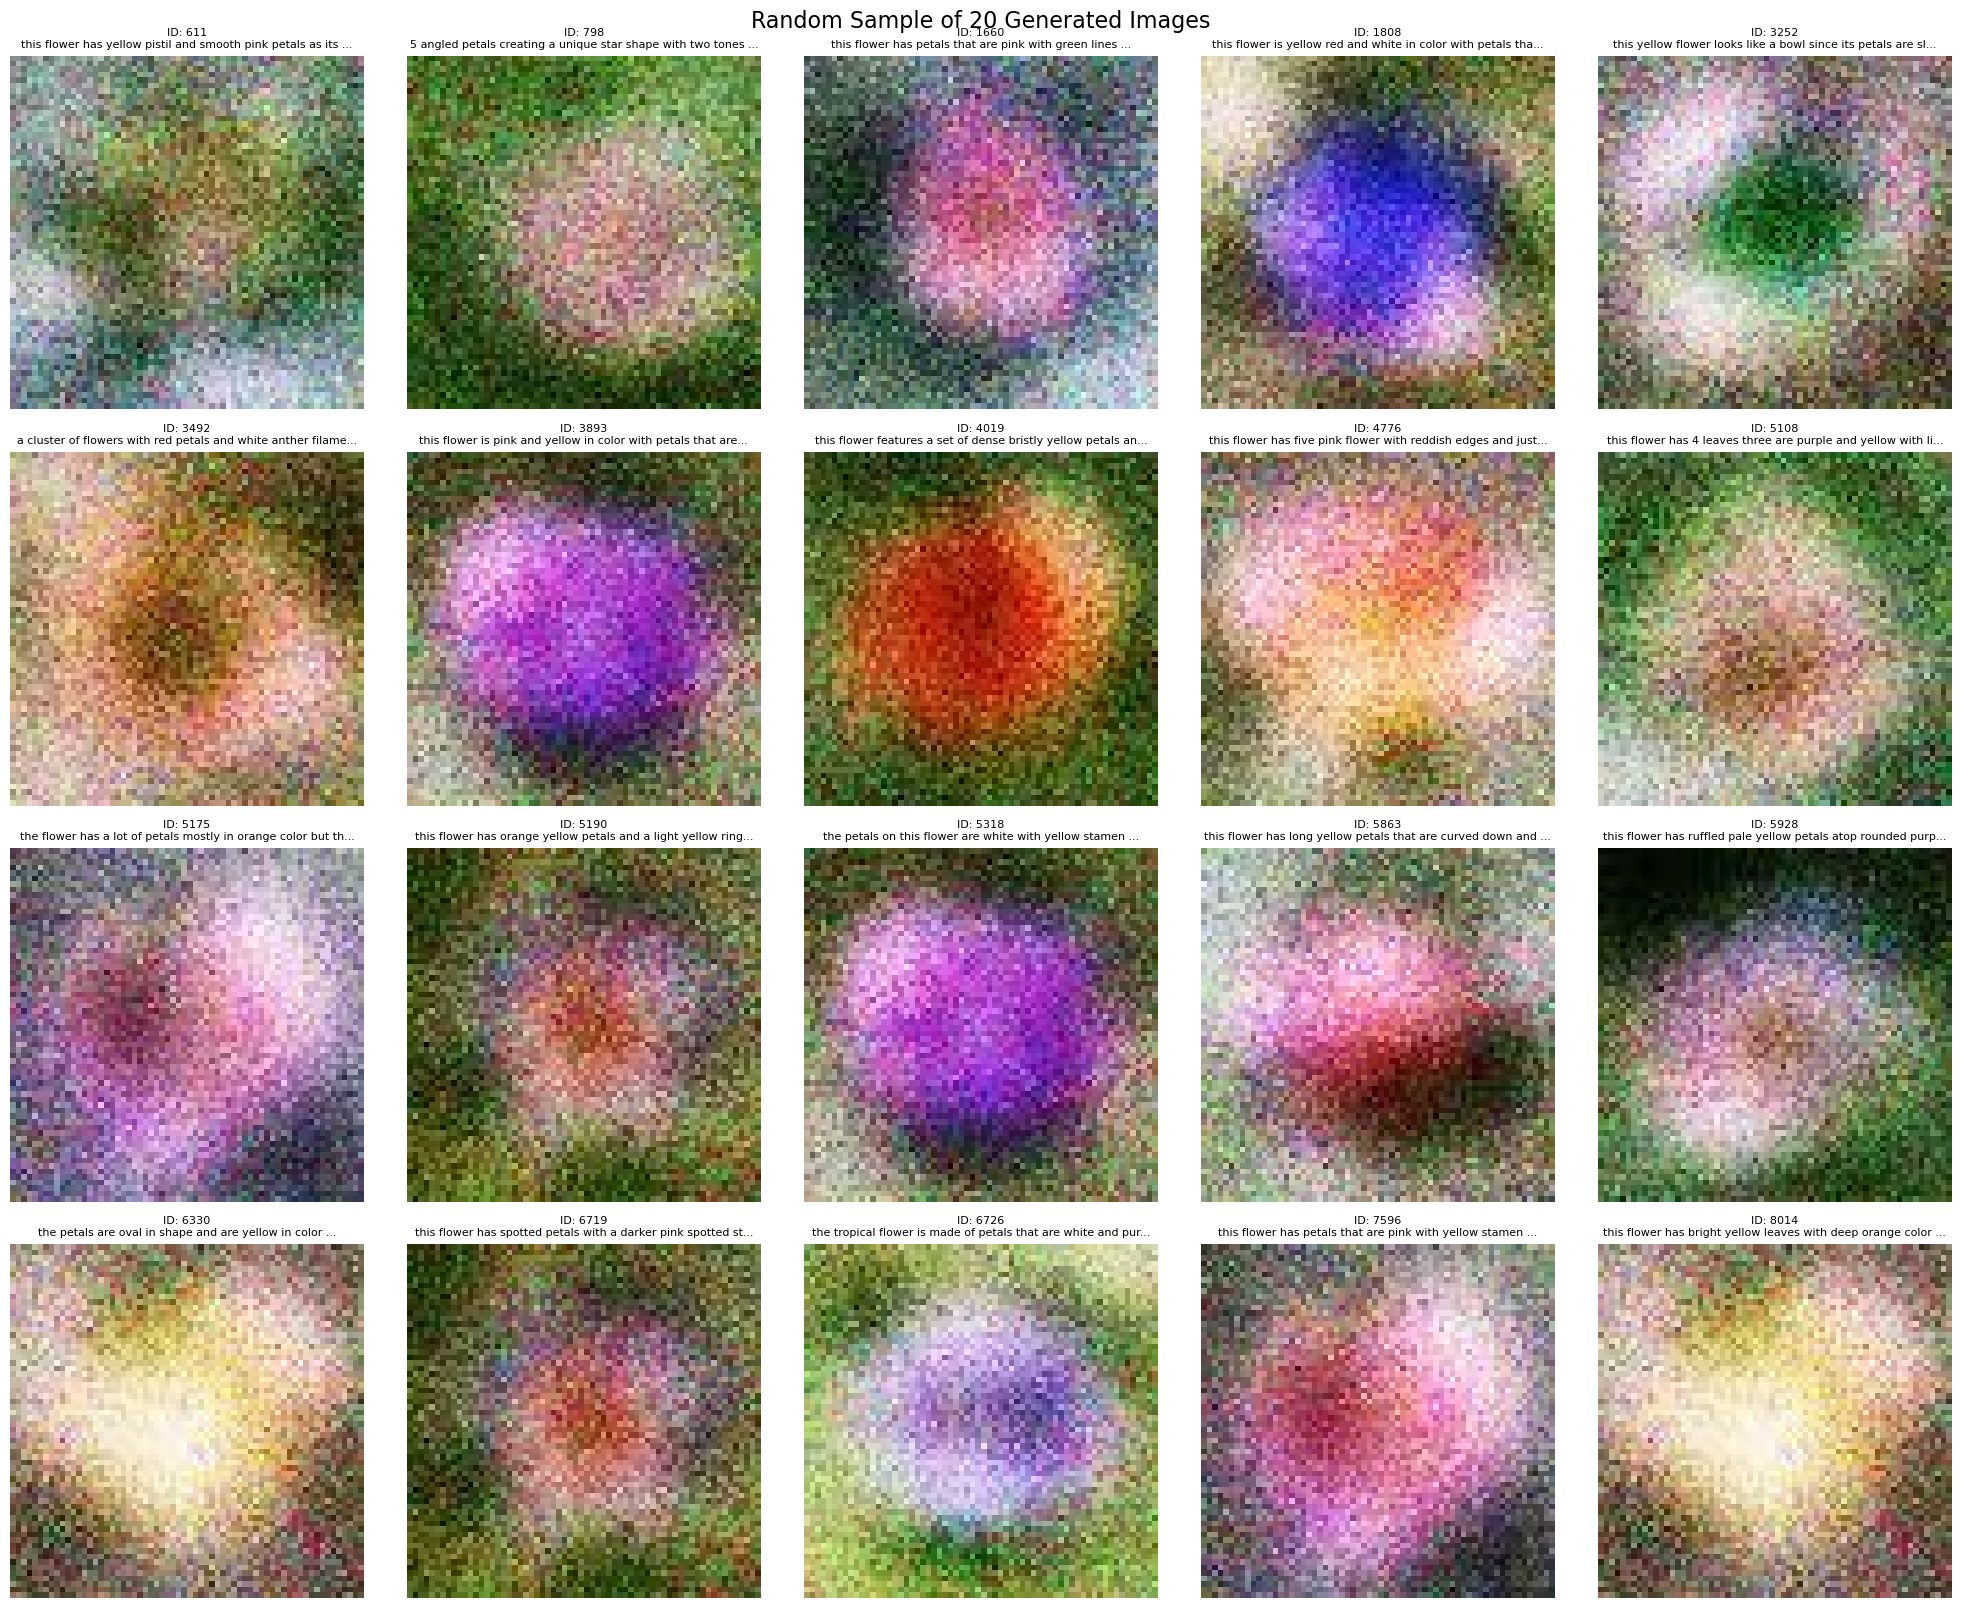


Total generated images: 819
Images directory: runs/20251115-172845/inference


In [ ]:
# Visualize 20 random generated images with their captions
import glob

# Load test data
data = pd.read_pickle('./dataset/testData.pkl')
test_captions = data['Captions'].values
test_ids = data['ID'].values

# Get all generated images from the current inference directory
image_files = sorted(glob.glob(inference_dir + '/inference_*.jpg'))

if len(image_files) == 0:
    print(f'⚠ No images found in {inference_dir}')
    print('Please run the inference cell first!')
else:
    # Randomly sample 20 images
    np.random.seed(42)  # For reproducibility
    num_samples = min(20, len(image_files))
    sample_indices = np.random.choice(len(image_files), size=num_samples, replace=False)
    sample_files = [image_files[i] for i in sorted(sample_indices)]

    # Create 4x5 grid
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        # Extract image ID from filename
        img_id = int(Path(img_path).stem.split('_')[1])
        
        # Find caption
        caption_idx = np.where(test_ids == img_id)[0][0]
        caption_ids = test_captions[caption_idx]
        
        # Decode caption
        caption_text = ''
        for word_id in caption_ids:
            word = id2word_dict[str(word_id)]
            if word != '<PAD>':
                caption_text += word + ' '
        
        # Load and display image
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'ID: {img_id}\n{caption_text[:60]}...', fontsize=8)
        axes[idx].axis('off')

    # Hide unused subplots if less than 20 images
    for idx in range(num_samples, 20):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Random Sample of {num_samples} Generated Images', fontsize=16, y=1.002)
    plt.show()

    print(f'\nTotal generated images: {len(image_files)}')
    print(f'Images directory: {inference_dir}')